In [5]:
import os
import sys
import time
import configparser
%matplotlib inline
%load_ext autoreload
%autoreload 2

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

config = configparser.ConfigParser()
config.read('config_jj.ini')

#TO BE CONFIGURED FROM CONFIG FILE
os.environ['ICTDIR'] = config['Paths']['ICTDIR']
os.environ["PATH"] = os.environ["PATH"] + config['Paths']['PATH_APPEND']
# Define the folder base path these are to run in local
base_path = config['Paths']['BASE_PATH']
path_to_wf = config['Paths']['PATH_TO_WF']
path_to_dst = config['Paths']['PATH_TO_DST']
print(os.environ["PATH"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/jjgomezcadenas/NEXT/IC-v2-on-master/bin:/Users/jjgomezcadenas/miniconda3/envs/IC-3.8-2024-06-08/bin:/Users/jjgomezcadenas/Software/geant4-11.2.2-build/bin:/Users/jjgomezcadenas/miniconda3/condabin:/Users/jjgomezcadenas/.juliaup/bin:/Users/jjgomezcadenas/.nix-profile/bin:/nix/var/nix/profiles/default/bin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/opt/X11/bin:/Library/Apple/usr/bin:/Library/TeX/texbin:/Users/jjgomezcadenas/.local/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/Users/jjgomezcadenas/.local/bin:/Users/jjgomezcadenas/NEXT/IC/bin:/Users/jjgomezcadenas/NEXT/IC/bin:/Users/jjgomezcadenas/NEXT/IC/bin:/Users/jjgomezcadenas/NEXT/IC/bin


In [110]:
import pandas as pd
import os
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [30]:
import histograms as hst

In [56]:
import invisible_cities.core.fit_functions as ifit

## Functions

In [11]:
def merge_hdfs(folderdata):
    dfs = []
    for root, _, files in os.walk(folderdata):
        for f in files:
            if f.endswith(('.h5', '.hdf5')):
                dfs.append(pd.read_hdf(os.path.join(root, f), '/DST/Events'))
    return pd.concat(dfs, ignore_index=True)

In [60]:
def compute_histogram_y_profile(h2, xedges, yedges, errMean=False):
    """
    Extract Y-profile statistics from a 2D histogram.

    For each X-bin (row of h2), compute:
    - y_mode: Y bin center with maximum weight (mode)
    - y_mean: weighted mean of Y values
    - y_std: weighted standard deviation of Y values

    Parameters:
    - h2: 2D NumPy array of histogram counts, shape (nx, ny)
    - xedges: 1D array of X bin edges (length nx+1)
    - yedges: 1D array of Y bin edges (length ny+1)

    Returns:
    - xp: 1D array of X bin centers (length nx)
    - y_mode: Y bin center of max weight per X-bin
    - y_mean: weighted mean of Y values per X-bin
    - y_std: weighted std deviation of Y values per X-bin
    """
    
    nx, ny = h2.shape
    xp = 0.5 * (xedges[:-1] + xedges[1:])
    yp = 0.5 * (yedges[:-1] + yedges[1:])

    y_mode, y_mean, y_std = [], [], []

    for i in range(nx):
        weights = h2[i]
        total = np.sum(weights)
        if total > 0:
            max_idx = np.argmax(weights)
            mode = yp[max_idx]
            mean = np.average(yp, weights=weights)
            var = np.average((yp - mean) ** 2, weights=weights)
            std = np.sqrt(var)
            if errMean:
                std = std/np.sqrt(total)
        else:
            mode, mean, std = np.nan, np.nan, np.nan

        y_mode.append(mode)
        y_mean.append(mean)
        y_std.append(std)

    return np.array(xp), np.array(y_mode), np.array(y_mean), np.array(y_std)

In [66]:
def road_s1(
    dfs1, nbins, xrange, yrange,
    figsize=(10, 4), nsigma=2.0, errMean=False,
    xlabel="DT", ylabel="Zrms²", title="Road Band"
):
    """
    Compute a 2D histogram of tz vs Zrms², fit a central line to max Y-bin values per X-bin,
    and define a road band as two parallel lines offset by ±nsigma × std per bin.

    Parameters
    ----------
    dfs1 : pd.DataFrame
        DataFrame with 'tz' and 's2w' columns.
    nbins : int
        Number of bins for 2D histogram.
    xrange : list
        X-axis range for histogram.
    yrange : list
        Y-axis range for histogram.
    figsize : tuple, optional
        Figure size.
    nsigma : float, optional
        Number of standard deviations for band width.
    errMean : bool, optional
        If True, use standard error of the mean.
    xlabel, ylabel, title : str
        Plot labels.

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame with rows inside the road band.
    """
    h2, xedges, yedges = np.histogram2d(
        dfs1.DT, dfs1.Zrms**2, bins=(nbins, nbins), range=[xrange, yrange]
    )

    fig, axs = plt.subplots(figsize=figsize)
    hst.plot_h2d(fig, axs, h2, xedges, yedges, xlabel, ylabel, title)

    xp, yp, y_mean, ystd = compute_histogram_y_profile(h2, xedges, yedges, errMean)
    
    yl = yp - nsigma * ystd
    yr = yp + nsigma * ystd


    # Fit envelope lines
    ff_c = ifit.fit(ifit.polynom, xp, yp, [1., 1.])
    ff_l = ifit.fit(ifit.polynom, xp, yl, [1., 1.])
    ff_u = ifit.fit(ifit.polynom, xp, yr, [1., 1.])

    #yfit = ff_c.fn(xp)

    #mean_std = np.nanmean(ystd)
    #offset = nsigma * mean_std

    #yl = np.maximum(yfit - offset, 0)  # ensure lower bound stays above zero
    #yr = yfit + offset

    axs.errorbar(xp, yp, yerr=ystd, fmt='o', ms=3, elinewidth=2, capsize=3, color='black')
    
    axs.plot(xp, ff_c.fn(xp), 'red', lw=2, label=f'central Fit: ')
    axs.plot(xp, ff_l.fn(xp), 'blue', lw=2, label=f'Lower Fit: -{nsigma}σ')
    axs.plot(xp, ff_u.fn(xp), 'green', lw=2, label=f'Upper Fit: +{nsigma}σ')
    
    #axs.plot(xp, yl, 'blue', lw=2, linestyle='--', label=f'-{nsigma}σ (parallel)')
    #axs.plot(xp, yr, 'green', lw=2, linestyle='--', label=f'+{nsigma}σ (parallel)')

    axs.legend()
    fig.tight_layout()
    plt.show()

    x = dfs1.DT.to_numpy()
    y = dfs1.Zrms.to_numpy() ** 2
    
    # Apply cut based on fit envelopes
    
    mask = (y >= ff_l.fn(x)) & (y <= ff_u.fn(x))
    
    #y_central = ff_c.fn(x)

    #lower_bound = np.maximum(y_central - offset, 0)
    #upper_bound = y_central + offset
    mask = (y >= lower_bound) & (y <= upper_bound)

    return dfs1[mask].copy()

In [78]:
def road_s1(
    dfs1, nbins, xrange, yrange,
    figsize=(10, 4), nsigma=2.0, errMean=False,
    xlabel="DT", ylabel="Zrms²", title="Road Band"
):
    """
    Build a band ("road") around the most probable Zrms² value in each DT bin and filter points within it.

    Parameters
    ----------
    dfs1 : pd.DataFrame
        DataFrame with 'DT' and 'Zrms' columns.
    nbins : int
        Number of bins for 2D histogram.
    xrange, yrange : list of float
        Histogram ranges for X (DT) and Y (Zrms²).
    figsize : tuple, optional
        Size of the matplotlib figure.
    nsigma : float, optional
        Multiplier of standard deviation to define the road band.
    errMean : bool, optional
        Use standard error instead of standard deviation per bin.
    xlabel, ylabel, title : str
        Axis and plot labels.

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame with points inside the road band.
    """
    h2, xedges, yedges = np.histogram2d(
        dfs1.DT, dfs1.Zrms**2, bins=(nbins, nbins), range=[xrange, yrange]
    )

    fig, axs = plt.subplots(figsize=figsize)
    hst.plot_h2d(fig, axs, h2, xedges, yedges, xlabel, ylabel, title)

    xp, yp, _, ystd = compute_histogram_y_profile(h2, xedges, yedges, errMean)

    yl = yp - nsigma * ystd
    yr = yp + nsigma * ystd

    ff_c = ifit.fit(ifit.polynom, xp, yp, [1., 1.])
    ff_l = ifit.fit(ifit.polynom, xp, yl, [1., 1.])
    ff_u = ifit.fit(ifit.polynom, xp, yr, [1., 1.])

    axs.errorbar(xp, yp, yerr=ystd, fmt='o', ms=3, elinewidth=2, capsize=3, color='black')
    axs.plot(xp, ff_c.fn(xp), 'red', lw=2, label='Central Fit')
    axs.plot(xp, ff_l.fn(xp), 'blue', lw=2, label=f'-{nsigma}σ Fit')
    axs.plot(xp, ff_u.fn(xp), 'green', lw=2, label=f'+{nsigma}σ Fit')

    axs.legend()
    fig.tight_layout()
    plt.show()

    x = dfs1.DT.to_numpy()
    y = dfs1.Zrms.to_numpy() ** 2

    lower_bound = ff_l.fn(x)
    upper_bound = ff_u.fn(x)
    mask = (y >= lower_bound) & (y <= upper_bound)

    return ff_c, ff_l, ff_u, dfs1[mask].copy()

In [120]:
def road_rs2e(
    dfs1, nbins, xrange, yrange,
    figsize=(10, 4), nsigma=2.0, errMean=False,
    xlabel="DT", ylabel="Zrms²", title="Road Band"
):
    """
    Build a band ("road") around the most probable Zrms² value in each DT bin and filter points within it.

    Parameters
    ----------
    dfs1 : pd.DataFrame
        DataFrame with 'DT' and 'Zrms' columns.
    nbins : int
        Number of bins for 2D histogram.
    xrange, yrange : list of float
        Histogram ranges for X (DT) and Y (Zrms²).
    figsize : tuple, optional
        Size of the matplotlib figure.
    nsigma : float, optional
        Multiplier of standard deviation to define the road band.
    errMean : bool, optional
        Use standard error instead of standard deviation per bin.
    xlabel, ylabel, title : str
        Axis and plot labels.

    Returns
    -------
    Tuple[FitResult, FitResult, FitResult, pd.DataFrame]
        Fit functions (central, lower, upper) and filtered DataFrame.
    """
    h2, xedges, yedges = np.histogram2d(
        dfs1.R, dfs1.S2e, bins=(nbins, nbins), range=[xrange, yrange]
    )

    fig, axs = plt.subplots(figsize=figsize)
    hst.plot_h2d(fig, axs, h2, xedges, yedges, xlabel, ylabel, title)

    xp, yp, _, ystd = compute_histogram_y_profile(h2, xedges, yedges, errMean)

    # Filter out invalid entries
    mask_valid = np.isfinite(yp) & np.isfinite(ystd)
    xp = xp[mask_valid]
    yp = yp[mask_valid]
    ystd = ystd[mask_valid]

    if len(xp) < 4:
        raise ValueError("Not enough valid points to fit a 3rd-degree polynomial.")

    yl = yp - nsigma * ystd
    yr = yp + nsigma * ystd

    ff_c = ifit.fit(ifit.polynom, xp, yp, [1., 1., 1., 1.])
    ff_l = ifit.fit(ifit.polynom, xp, yl, [1., 1., 1., 1.])
    ff_u = ifit.fit(ifit.polynom, xp, yr, [1., 1., 1., 1.])

    axs.errorbar(xp, yp, yerr=ystd, fmt='o', ms=3, elinewidth=2, capsize=3, color='black')
    axs.plot(xp, ff_c.fn(xp), 'red', lw=2, label='Central Fit')
    axs.plot(xp, ff_l.fn(xp), 'blue', lw=2, label=f'-{nsigma}σ Fit')
    axs.plot(xp, ff_u.fn(xp), 'green', lw=2, label=f'+{nsigma}σ Fit')

    axs.legend()
    fig.tight_layout()
    plt.show()

    x = dfs1.R.to_numpy()
    y = dfs1.S2e.to_numpy()

    lower_bound = ff_l.fn(x)
    upper_bound = ff_u.fn(x)
    mask = (y >= lower_bound) & (y <= upper_bound)

    return ff_c, ff_l, ff_u, dfs1[mask].copy()

In [147]:
def fit_lifetime(df, nbins=15, tzrange=[200.0, 1200.0], s2range=[4000, 4800], figsize=(10, 4)):
    """
    Fit an exponential decay model to the S2 area (S2e) as a function of drift time (tz).

    The function profiles `df.tz` vs `df.s2e` and fits the model:
        S2e(tz) ≈ const * exp(-tz / τ)

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with columns `tz` (drift time) and `s2e` (S2 signal area).
    nbins : int, optional
        Number of bins used for profile histogram (default is 15).
    tzrange : list of float, optional
        Drift time range [min, max] to include in the profile (default is [200.0, 1200.0]).
    s2range : list of float, optional
        Y-axis range for plotting S2e (default is [4000, 4800]).

    Returns
    -------
    tuple of float
        Fitted parameters (const, lambda), where:
            - const: initial S2e amplitude
            - lambda: exponential decay rate (units: 1/μs)
    """
    
    def expo_seed(x, y, eps=1e-12):
        """
        Estimate the seed for a exponential fit to the input data.
        """
        x, y  = zip(*sorted(zip(x, y)))
        const = y[0]
        slope = (x[-1] - x[0]) / np.log(y[-1] / (y[0] + eps))
        seed  = const, slope
        return seed

     # Compute 2D histogram of tz vs s2e
    h2, xedges, yedges = np.histogram2d(
        dfs1.DT, dfs1.S2e, bins=(nbins, nbins), range=[tzrange, s2range]
    )

    # Plot histogram
    fig, axs = plt.subplots(figsize=figsize)
    hst.plot_h2d(fig, axs, h2, xedges, yedges, xlabel="tz", ylabel="s2e", title="Lifetime")
    
    # Extract profile max and std per X-bin
    xp, yp, y_mean, ystd = compute_histogram_y_profile(h2, xedges, yedges)
    
    valid_points = ystd > 0

    x    = xp [valid_points]
    y    = yp [valid_points]
    yu   = ystd [valid_points]
    ym   = y_mean [valid_points]
    seed = expo_seed(x, y)
    ff   = ifit.fit(ifit.expo, x, y, seed, sigma=yu)
    

    # Compute profile histogram
    #x, y, yu = hh.profile1d(df.tz, df.s2e, nbins, tzrange)

    # Fit exponential decay model
    #ff = fit.fit_profile_1d_expo(df.tz, df.s2e, nbins, tzrange)
    const, lamda = ff.values

    # Plot profile with error bars
    plt.errorbar(x, y, yerr=yu, fmt='o', ms=3, elinewidth=2, capsize=3, color='black')
    #plt.errorbar(x, ym, yerr=yu, fmt='s', ms=3, elinewidth=2, capsize=3, color='red')

    # Plot fit result
    plt.plot(x, ff.fn(x), "r-", lw=2)
    plt.ylim(bottom=s2range[0], top=s2range[1])

    # Annotate with fit results (convert decay rate to lifetime)
    c0 = f"constant = {const:7.2f} ± {ff.errors[0]:7.3f} pes"
    c1 = f"λ = {-lamda/1e3:7.2f} ± {ff.errors[1]/1e3:7.3f} ms"

    plt.gca().text(
        0.05, 0.95, f"{c0}\n{c1}",
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
    )

    plt.xlabel('DT')
    plt.ylabel('S2e')
    plt.title('Fit S2e vs DT')
    plt.show()

    return const, lamda

## Analysis

### Read data

In [20]:
run_number = 15502
ldc="/ldc1"
dstpath =f"{base_path}{run_number}{path_to_dst}"
print(f"path to dst files = {dstpath}")

path to dst files = /Users/jjgomezcadenas/NEXT/analysis/15502/hdf5/prod/v2.3.1/20250512/sophronia/trigger1


In [21]:
for dirpath, dirnames, filenames in os.walk(dstpath):
    print(dirpath, dirnames,  len(filenames))

/Users/jjgomezcadenas/NEXT/analysis/15502/hdf5/prod/v2.3.1/20250512/sophronia/trigger1 ['ldc6', 'ldc1', 'ldc7', 'ldc2', 'ldc5', 'ldc4', 'ldc3'] 0
/Users/jjgomezcadenas/NEXT/analysis/15502/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc6 [] 2418
/Users/jjgomezcadenas/NEXT/analysis/15502/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc1 [] 2419
/Users/jjgomezcadenas/NEXT/analysis/15502/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc7 [] 2417
/Users/jjgomezcadenas/NEXT/analysis/15502/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc2 [] 2417
/Users/jjgomezcadenas/NEXT/analysis/15502/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc5 [] 2417
/Users/jjgomezcadenas/NEXT/analysis/15502/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc4 [] 2416
/Users/jjgomezcadenas/NEXT/analysis/15502/hdf5/prod/v2.3.1/20250512/sophronia/trigger1/ldc3 [] 2416


In [22]:
df = merge_hdfs(dstpath)

In [23]:
df.head()

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,2199413,1.749095e+09,0,0,1,1,150.0,4.686683,18.197773,1215050.0,...,17,187.457886,187.457886,1.071617,-401.499141,109.642478,416.200712,2.875010,12.856686,11.400789
1,2199420,1.749095e+09,0,0,1,1,125.0,1.335413,4.234182,1079800.0,...,16,324.685516,324.685516,3.295849,266.674212,-340.390462,432.412768,-0.906237,12.078571,14.531678
2,2199427,1.749095e+09,0,0,9,1,125.0,0.952822,2.989482,650925.0,...,19,752.557556,752.557556,1.732499,-62.609459,-431.024275,435.547782,-1.715045,13.049300,13.490991
3,2199427,1.749095e+09,1,0,9,1,200.0,1.246975,5.937012,651625.0,...,19,751.857544,751.857544,1.732499,-62.609459,-431.024275,435.547782,-1.715045,13.049300,13.490991
4,2199427,1.749095e+09,2,0,9,1,225.0,1.629565,7.993669,652150.0,...,19,751.332520,751.332520,1.732499,-62.609459,-431.024275,435.547782,-1.715045,13.049300,13.490991


In [83]:
df.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [41]:
ldf = len(np.unique(df['event']))
print(f"NEvent full dataset : {ldf}")

NEvent full dataset : 2842942


#### Number of S1 is very large

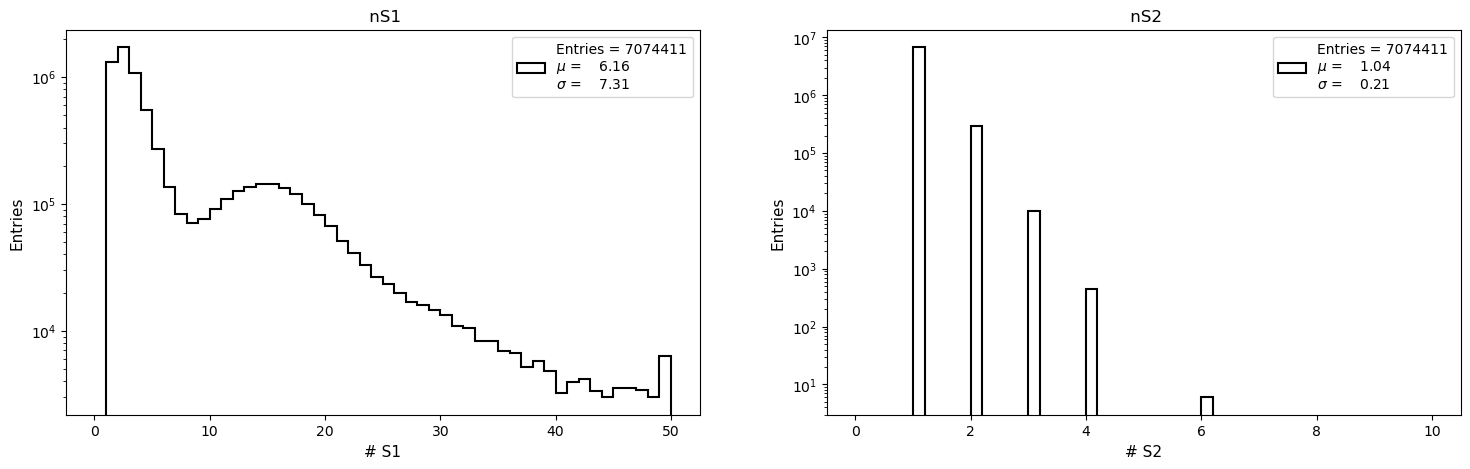

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
_ = hst.h1d(df.nS1, 50, [0,50], 
            ax = ax[0])
hst.plot_histo(hst.PlotLabels(x='# S1', y='Entries', title=" nS1"), ax[0], log=True)
           
_ = hst.h1d(df.nS2, 50, [0,10], 
            ax = ax[1])
hst.plot_histo(hst.PlotLabels(x='# S2', y='Entries', title=" nS2"), ax[1], log=True)
           
plt.show()

### Impose nS1 =1, nS2=1

In [40]:
dfs1= df[(df['nS1']==1) & (df['nS2']==1)]

In [43]:
ldfs1 = len(np.unique(dfs1['event']))
print(f"NEvent S1 = 1 & S2=1 : {len(np.unique(dfs1['event']))}")
print(f"eff:{(ldfs1/ldf)*100:.2f}%")

NEvent S1 = 1 & S2=1 : 1301696
eff:45.79%


### DT vs Zrms

#### 2D histogram

In [52]:
h2zdt, xedges, yedges = np.histogram2d(dfs1.DT, dfs1.Zrms**2, bins=(100, 1000), range=[[0.0, 1350.0], [0, 50.0]], 
                                    weights=np.ones(len(dfs1.DT)))

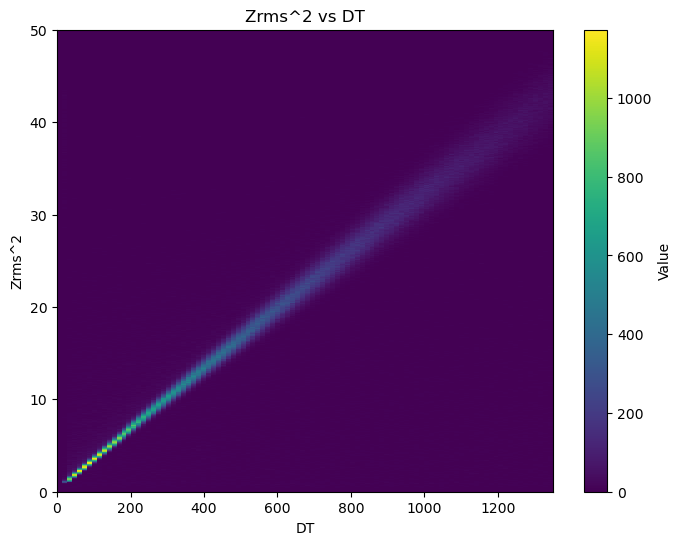

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
hst.plot_h2d(fig, ax, h2zdt, xedges, yedges, xlabel="DT", ylabel="Zrms^2", title="Zrms^2 vs DT")

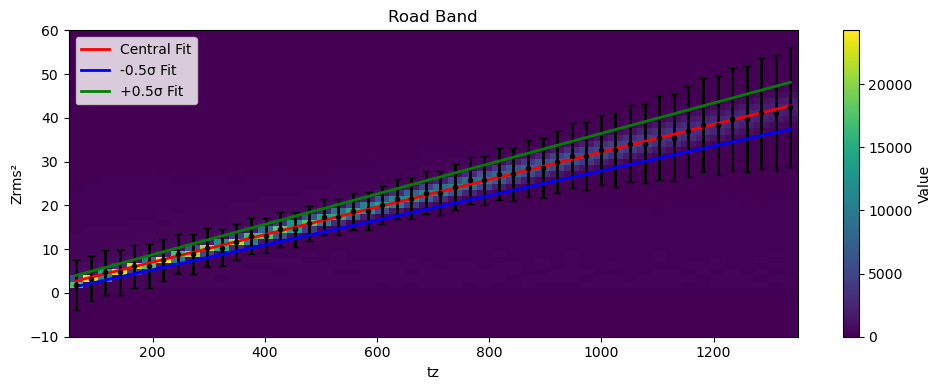

In [79]:
ff_c, ff_l, ff_u, dfrs1 = road_s1(
    dfs1, nbins=50, xrange=[50.0, 1350.0], yrange=[-10.0, 60.0],
    figsize=(10, 4), nsigma=0.5,
    xlabel="tz", ylabel="Zrms²", title="Road Band"
)

In [124]:
ldfrs1 = len(np.unique(dfrs1['event']))
print(f"NEvent filtered road : {len(np.unique(dfrs1['event']))}")
print(f"eff:{(ldfrs1/ldf)*100:.2f}%")

NEvent filtered road : 1100539
eff:38.71%


#### Correlation between S2w and Zrms (must be lineal)

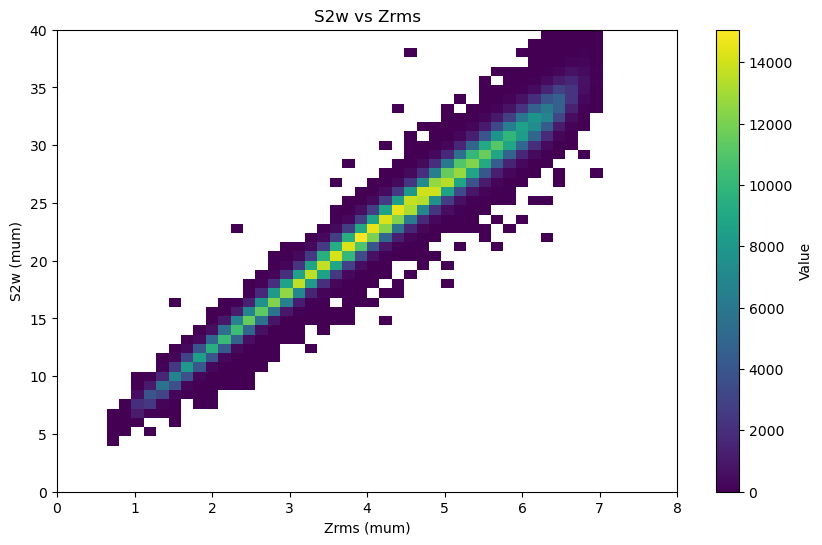

In [125]:
_ = hst.h2d(dfrs1.Zrms, dfrs1.S2w, np.ones(len(dfrs1.S2w)), 50, 50, [0.0, 8.0], [0.0, 40.0], 
           pltLabels = hst.PlotLabels(x='Zrms (mum)', y='S2w (mum)', title="S2w vs Zrms"))

#### Correlation between S2e and S1e

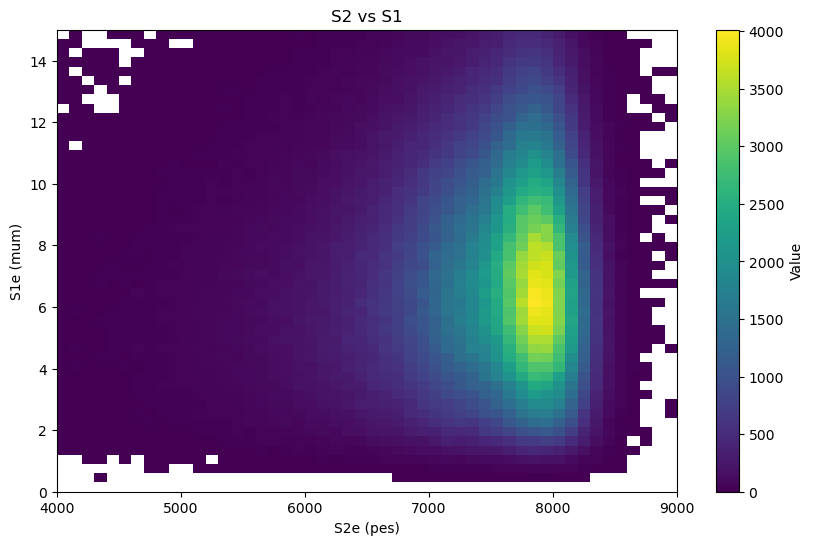

In [126]:
_ = hst.h2d(dfrs1.S2e, dfrs1.S1e, np.ones(len(dfrs1.S2e)), 50, 50, [4000.0, 9000.0], [0.0, 15.0], 
           pltLabels = hst.PlotLabels(x='S2e (pes)', y='S1e (mum)', title="S2 vs S1"))

#### S2e and DT

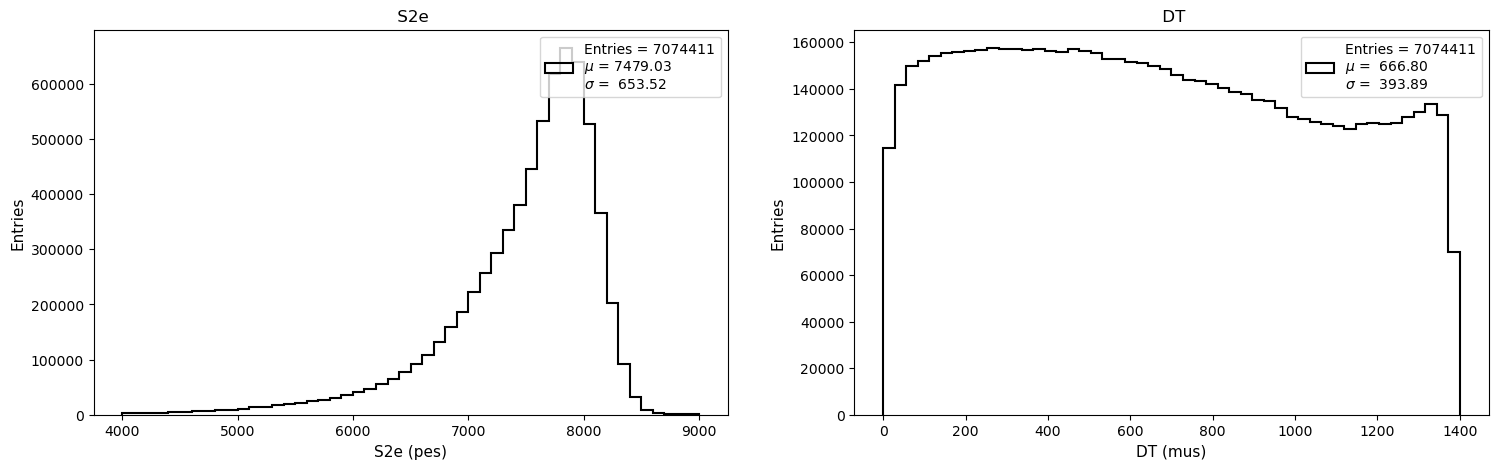

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
n, n, mu, std = hst.h1d(df.S2e, 50, [4000,9000], 
            ax = ax[0])
hst.plot_histo(hst.PlotLabels(x='S2e (pes)', y='Entries', title=" S2e"), ax[0], log=False)
           
_ = hst.h1d(df.DT, 50, [0,1400], 
            ax = ax[1])
hst.plot_histo(hst.PlotLabels(x='DT (mus)', y='Entries', title=" DT"), ax[1], log=False)
           
plt.show()

In [128]:
print(f"Raw S2e: sigma/mu = {2.3*std/mu}")

Raw S2e: sigma/mu = 0.2009744334142143


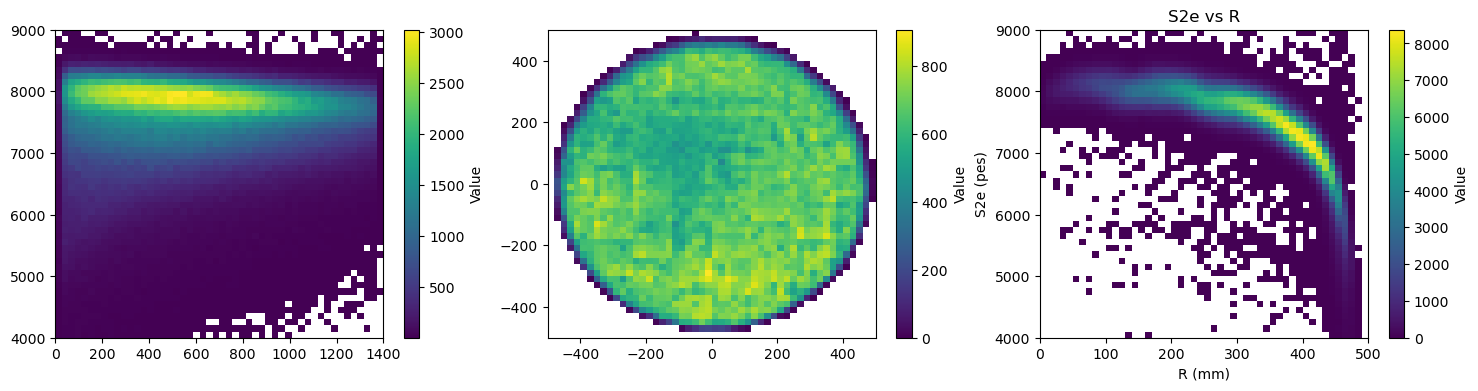

In [129]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
_ = hst.h2d(dfrs1.DT, dfrs1.S2e, np.ones(len(dfrs1.S2e)), 50, 50, [0.0, 1400.0],[4000.0, 9000.0], vmin=1, 
           ax=ax[0], pltLabels = hst.PlotLabels(x='DT (mus)', y='S2e (pes)', title="S2 vs tz"))
_ = hst.h2d(dfrs1.X, dfrs1.Y, np.ones(len(dfrs1.X)),50, 50, [-500.0, 500.0], [-500.0, 500.0], 
           ax=ax[1], pltLabels = hst.PlotLabels(x='X (mm)', y='Y (mm)', title="X vs Y"))
_ = hst.h2d(dfrs1.R, dfrs1.S2e, np.ones(len(dfrs1.R)),50, 50, [0.0, 500.0], [4000.0, 9000.0], 
           ax=ax[2], pltLabels = hst.PlotLabels(x='R (mm)', y='S2e (pes)', title="S2e vs R"))
plt.show()

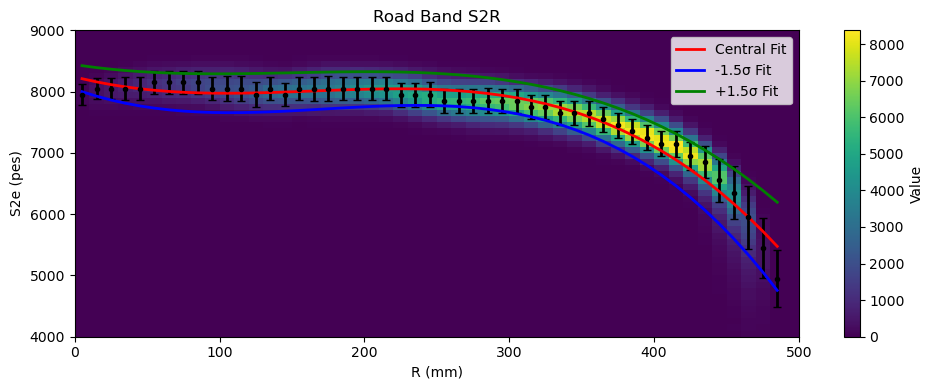

In [132]:
ff_c, ff_l, ff_u, dfrs2 = road_rs2e(
    dfrs1, nbins=50, xrange=[0.0, 500.0], yrange=[4000.0, 9000.0],
    figsize=(10, 4), nsigma=1.5,
    xlabel="R (mm)", ylabel="S2e (pes)", title="Road Band S2R"
)

In [133]:
ldfrs2 = len(np.unique(dfrs2['event']))
print(f"NEvent filtered road : {ldfrs2}")
print(f"eff:{(ldfrs2/ldf)*100:.2f}%")

NEvent filtered road : 920415
eff:32.38%


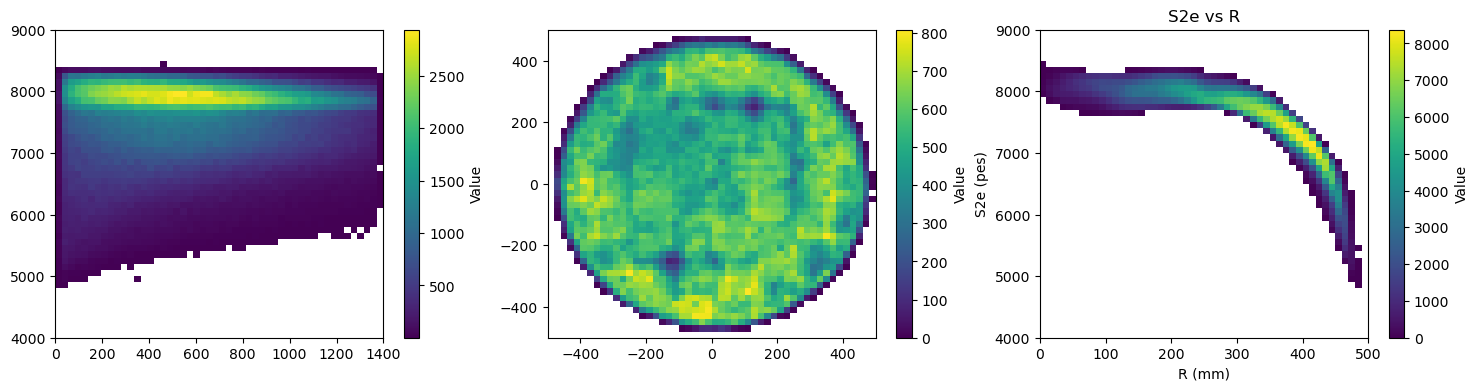

In [134]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
_ = hst.h2d(dfrs2.DT, dfrs2.S2e, np.ones(len(dfrs2.S2e)), 50, 50, [0.0, 1400.0],[4000.0, 9000.0], vmin=1, 
           ax=ax[0], pltLabels = hst.PlotLabels(x='DT (mus)', y='S2e (pes)', title="S2 vs tz"))
_ = hst.h2d(dfrs2.X, dfrs2.Y, np.ones(len(dfrs2.X)),50, 50, [-500.0, 500.0], [-500.0, 500.0], 
           ax=ax[1], pltLabels = hst.PlotLabels(x='X (mm)', y='Y (mm)', title="X vs Y"))
_ = hst.h2d(dfrs2.R, dfrs2.S2e, np.ones(len(dfrs2.R)),50, 50, [0.0, 500.0], [4000.0, 9000.0], 
           ax=ax[2], pltLabels = hst.PlotLabels(x='R (mm)', y='S2e (pes)', title="S2e vs R"))
plt.show()

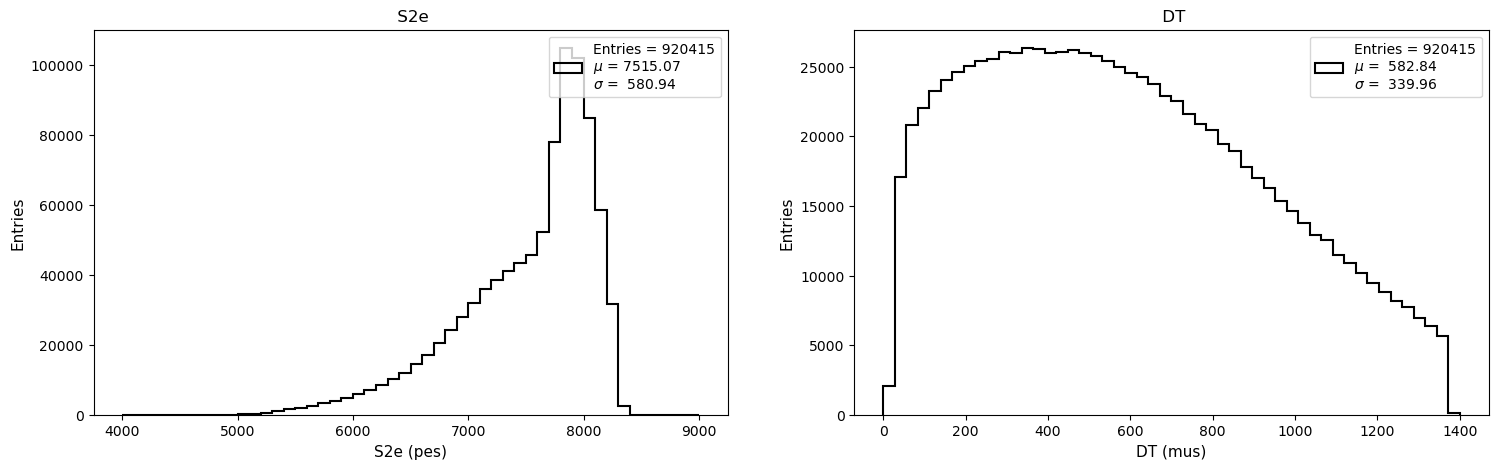

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
n, n, mu, std = hst.h1d(dfrs2.S2e, 50, [4000,9000], 
            ax = ax[0])
hst.plot_histo(hst.PlotLabels(x='S2e (pes)', y='Entries', title=" S2e"), ax[0], log=False)
           
_ = hst.h1d(dfrs2.DT, 50, [0,1400], 
            ax = ax[1])
hst.plot_histo(hst.PlotLabels(x='DT (mus)', y='Entries', title=" DT"), ax[1], log=False)
           
plt.show()

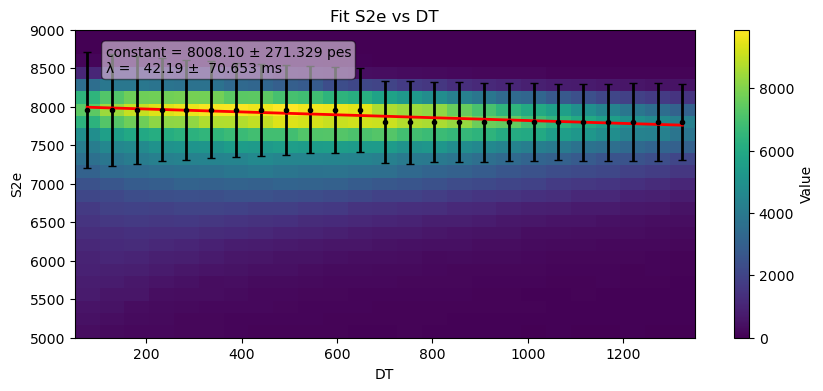

In [148]:
const, lamda = fit_lifetime(dfrs2, nbins=25, tzrange=[50.0, 1350.0], s2range=[5000, 9000])